In [100]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

import multiprocessing
num_cores = multiprocessing.cpu_count()

from scipy.integrate import quad

%matplotlib inline

In [101]:
import TA_gamma as tat

In [102]:
Uinf = 1

In [103]:
c = 1
ξ1 = 0.1*c
ξ2 = 0.9*c
η1 = np.deg2rad(10.)
η2 = np.deg2rad(-10.)


In [104]:
ξ_pl = np.linspace(0,c,num=250,endpoint=True)
y_pl = np.zeros_like(ξ_pl)

for ii in range(len(ξ_pl)):
    if ξ_pl[ii] <= ξ1:
        y_pl[ii] = η1*(ξ_pl[ii]-ξ1)
    elif ξ_pl[ii] >= ξ2:
        y_pl[ii] = η2*(ξ_pl[ii]-ξ2)

In [105]:
α_th = tat.flap_slat(ξ1,ξ2,η1,η2,c,0,0)
α_th

0.0

In [106]:
α = np.deg2rad(0.)

In [107]:
n = 35
A_fs = tat.flap_slat(ξ1,ξ2,η1,η2,c,n,α)

In [108]:
θ_af = np.logspace(-4,0,num=1500,endpoint=True)*np.pi
#θ_eps = np.linspace(5e-2,np.pi,num=200,endpoint=True)
ξ_af = c/2*(1-np.cos(θ_af))
#x_eps = c/2*(1-np.cos(θ))

In [109]:
γ_fs1 = tat.γ(θ_af,A_fs, Uinf)

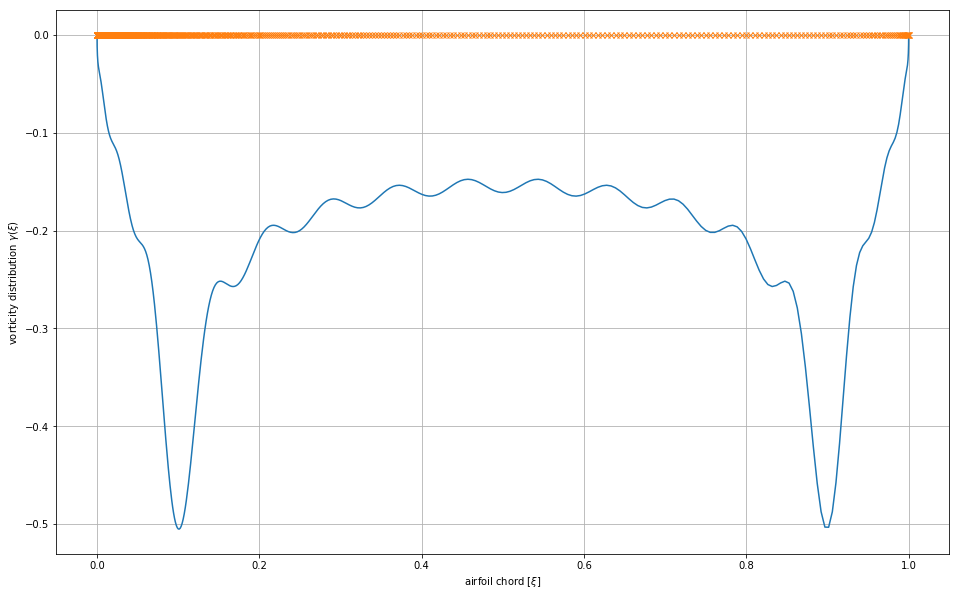

In [110]:
plt.figure(figsize=(16,10))

plt.plot(ξ_af,γ_fs1,label=r'$\gamma$')
if np.abs(γ_fs1[0]) > 3:
    plt.ylim([-3,1])
#plt.xlim([0.0,0.02])
plt.plot(ξ_af, np.zeros_like(ξ_af),'x')

#for ii in range(len(A_fs)):
#    if ii == 0:
#        plt.plot(ξ_af,-2*Uinf*A_fs[ii]*((1+np.cos(θ_af))/np.sin(θ_af)),label=r'$A_'+str(ii)+'$')
#    else:
#        plt.plot(ξ_af,-2*Uinf*A_fs[ii]*(np.sin(ii*θ_af)),label=r'$A_{'+str(ii)+'}$')
    

plt.xlabel(r'airfoil chord $[\xi]$')
plt.ylabel(r'$\gamma(\xi)$')
plt.title(r'vorticity distribution $\gamma(\xi)$')
#plt.legend()
plt.grid();

In [111]:
A_fs

array([ 0.        ,  0.13333333,  0.        ,  0.06933333,  0.        ,
       -0.00337067,  0.        , -0.03106255,  0.        , -0.01165687,
        0.        ,  0.01442611,  0.        ,  0.0149059 ,  0.        ,
       -0.00334482,  0.        , -0.01305136,  0.        , -0.00389877,
        0.        ,  0.00859001,  0.        ,  0.00761284,  0.        ,
       -0.00329348,  0.        , -0.00819274,  0.        , -0.00143232,
        0.        ,  0.00638526,  0.        ,  0.00461774,  0.        ,
       -0.00321735])

In [112]:
xx = np.linspace(-1, 2, 102)
yy = np.linspace(-1, 1, 102)
xw, yw = np.meshgrid(xx, yy)


In [113]:
def int_γ_u(x,y,A,Uinf,c):
    return quad(tat.du,0,c,args=(x,y,A,Uinf,c))[0]

def int_γ_v(x,y,A,Uinf,c):
    return quad(tat.dv,0,c,args=(x,y,A,Uinf,c))[0]

In [114]:
nx, ny = xw.shape

uw = np.zeros_like(xw)
vw = np.zeros_like(xw)

#for jj in range(ny):
#    for ii in range(nx):
        #uw[ii,jj] = quad(tat.du,0,c,args=(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c))[0]
        #vw[ii,jj] = quad(tat.dv,0,c,args=(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c))[0]
        # uw[ii,jj] = int_γ_u(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c)
        # vw[ii,jj] = int_γ_v(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c)
uw = Parallel(n_jobs=num_cores)(delayed(int_γ_u)(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c) for jj in range(ny) for ii in range(nx))
vw = Parallel(n_jobs=num_cores)(delayed(int_γ_v)(xw[ii,jj],yw[ii,jj],A_fs,Uinf,c) for jj in range(ny) for ii in range(nx))

In [115]:
uw = np.array(uw).reshape(nx,ny,order='F')
vw = np.array(vw).reshape(nx,ny,order='F')

uw += Uinf*np.cos(α)
vw += Uinf*np.sin(α)

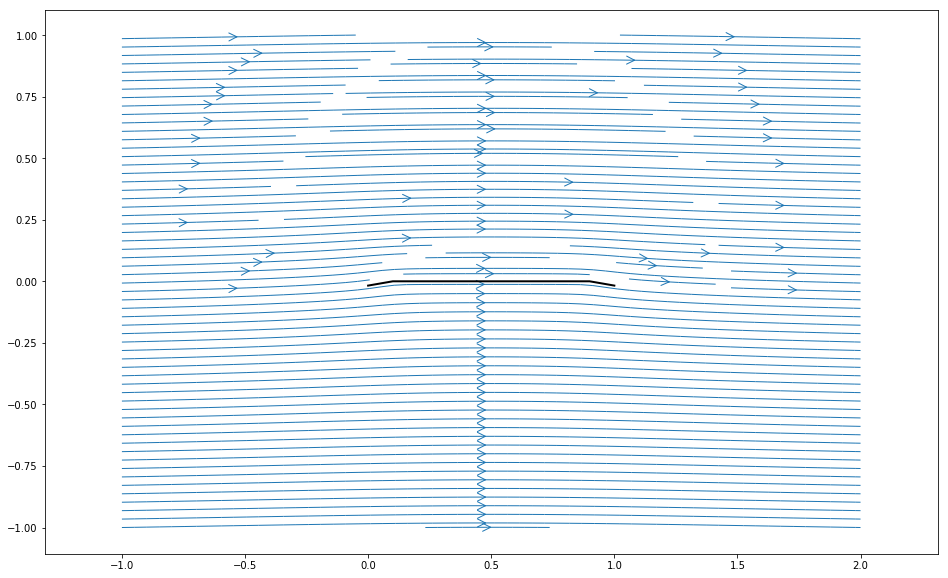

In [116]:
plt.figure(figsize=(16,10))
plt.streamplot(xw, yw, uw, vw, density=2, linewidth=1, arrowsize=2, arrowstyle='->')
plt.plot(ξ_pl,y_pl,'k',lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('streamlines of velocity field around the airfoil')
plt.axis('equal');

In [117]:
Cp = np.zeros_like(xw)
Cp = 1 - (uw**2+vw**2)/Uinf*2

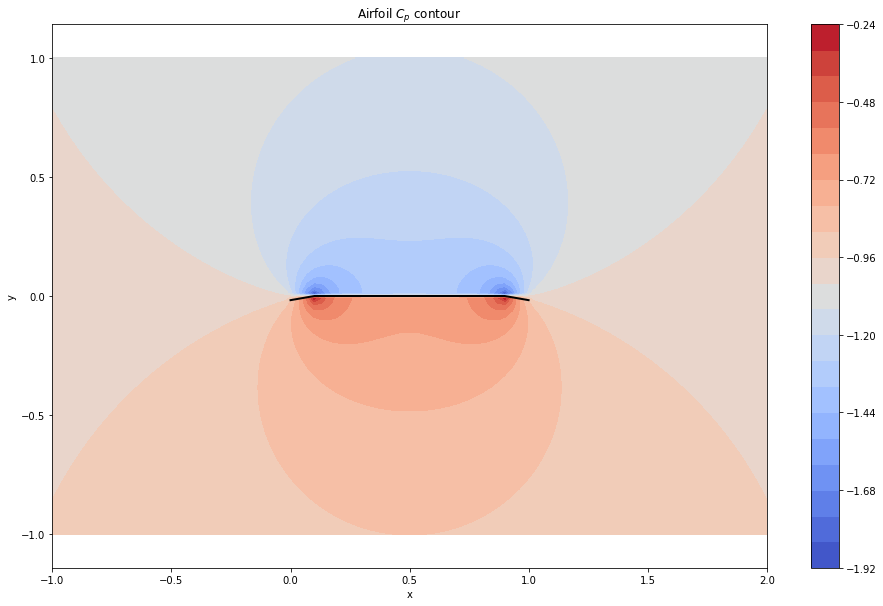

In [118]:
plt.figure(figsize=(16,10))
cm =plt.contourf(xw,yw,Cp,25,cmap='coolwarm')
plt.colorbar(cm)
plt.title('Airfoil $C_p$ contour')
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.plot(ξ_pl,y_pl,'k',lw=2)
plt.axis('equal');

In [119]:
#Parallel(n_jobs=nu)(delayed(self.compute_tf)(i, j) for j in column_list for i in row_list)